In [127]:
from typing import List

import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt 

In [128]:
COLUMNS: List = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

In [162]:
zn: pd.DataFrame = yf.download(tickers="CLG25.NYM", interval="5m", start="2024-11-01")
zb: pd.DataFrame = yf.download(tickers="CLH25.NYM", interval="5m", start="2024-11-01")


def drop_multi_index(data: pd.MultiIndex, ticker: str) -> pd.DataFrame:
    
    new_data = {}

    for k in COLUMNS:
        new_data[k] = data[k][ticker]
    
    return pd.DataFrame(new_data)


zn = drop_multi_index(data=zn, ticker="CLG25.NYM").dropna()
zb = drop_multi_index(data=zb, ticker="CLH25.NYM").dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Datetime'>

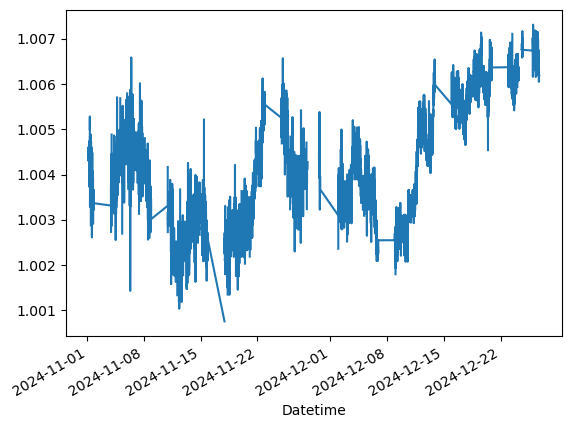

In [163]:
spread = (zn / zb)["Close"]
spread.plot()

In [177]:
fair_value = spread.ewm(halflife=10).mean().shift(1)
vol = spread.ewm(halflife=10).std().shift(1)
upper_band = fair_value + 2 * vol
lower_band = fair_value - 2 * vol

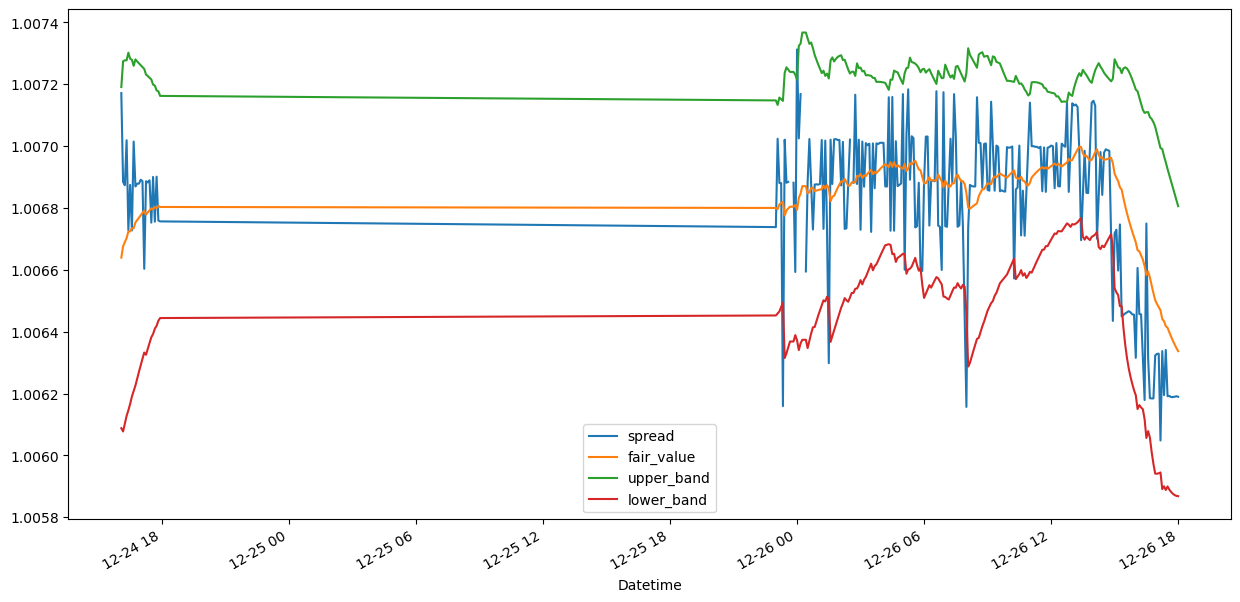

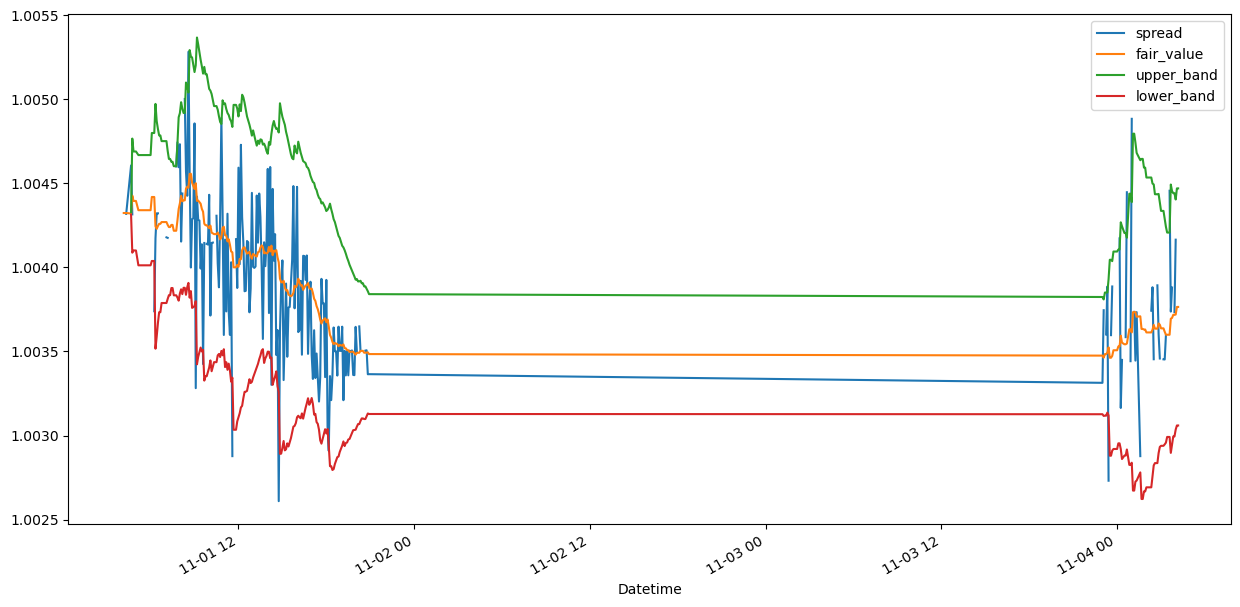

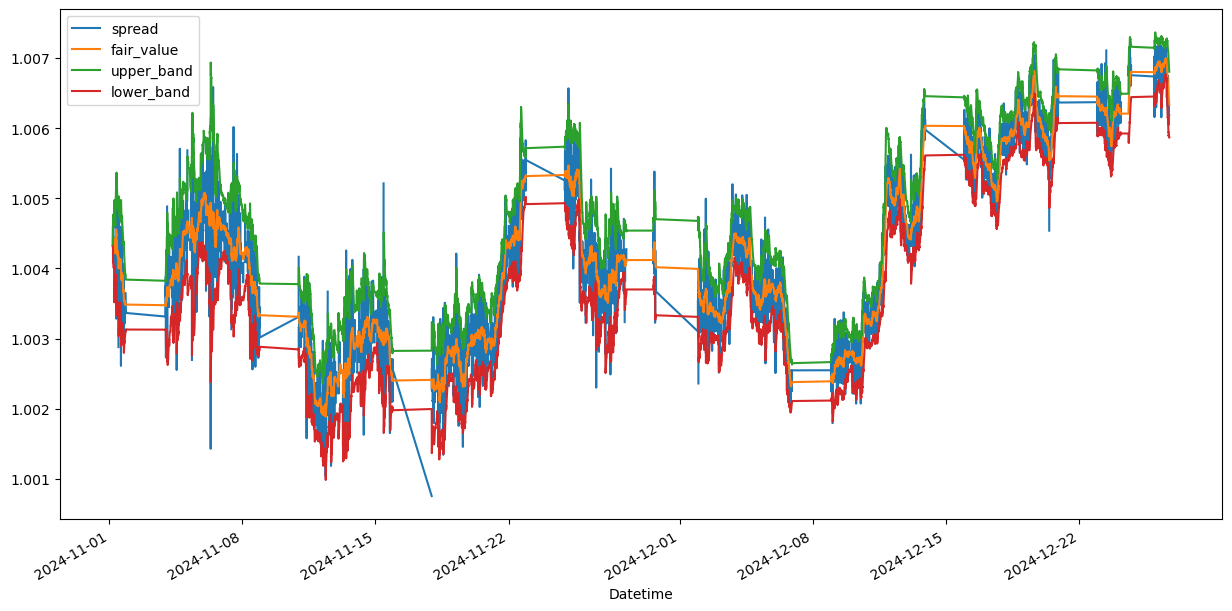

In [178]:
signal_data = pd.concat([spread, fair_value, upper_band, lower_band], axis=1)
signal_data.columns = ["spread", "fair_value", "upper_band", "lower_band"]

signal_data.tail(252).plot(figsize=(15, 7.5))
plt.show()

signal_data.head(252).plot(figsize=(15, 7.5))
plt.show()

signal_data.plot(figsize=(15, 7.5))
plt.show()

<Axes: xlabel='Datetime'>

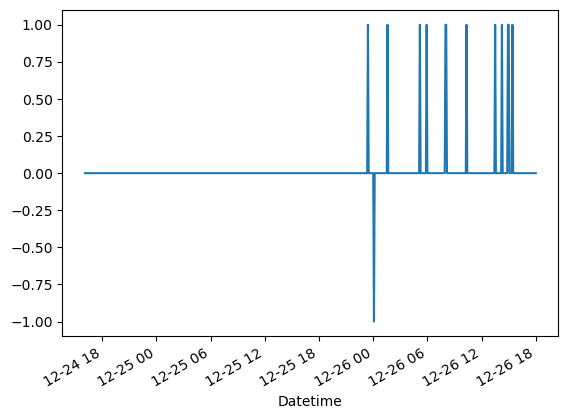

In [180]:
ev = (fair_value - spread) / spread
buy_signal = 1 * (spread <= lower_band)
short_signal = -1 * (spread >= upper_band)
signal = buy_signal + short_signal

# Shift to ensure the signal is applies to the next period's return - shift twice to test robustness
signal = signal.shift(1)

signal.tail(252).plot()

In [181]:
final_signal = pd.Series([])

for i, (date, s) in enumerate(signal.items()):
    
    if s == 1 or ((final_signal.iloc[i-1] == 1 if i != 0 else False) and spread.iloc[i-1] <= fair_value.iloc[i-1]):
        final_signal[date] = 1
    elif s == -1 or ((final_signal.iloc[i-1] == -1 if i != 0 else False) and spread.iloc[i-1] >= fair_value.iloc[i-1]):
        final_signal[date] = -1
    else:
        final_signal[date] = 0

final_signal = pd.Series(final_signal)
final_signal

2024-11-01 04:00:00+00:00    0
2024-11-01 04:10:00+00:00    0
2024-11-01 04:15:00+00:00    0
2024-11-01 04:20:00+00:00    0
2024-11-01 04:40:00+00:00    0
                            ..
2024-12-26 17:40:00+00:00    0
2024-12-26 17:45:00+00:00    0
2024-12-26 17:50:00+00:00    0
2024-12-26 17:55:00+00:00    0
2024-12-26 18:00:00+00:00    0
Length: 9760, dtype: int64

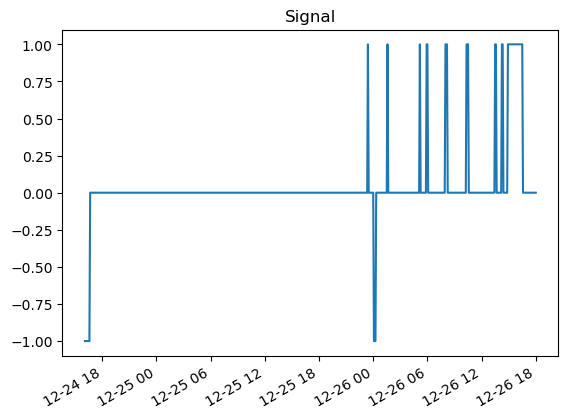

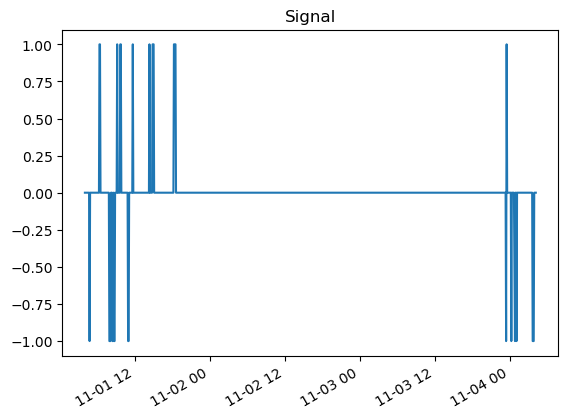

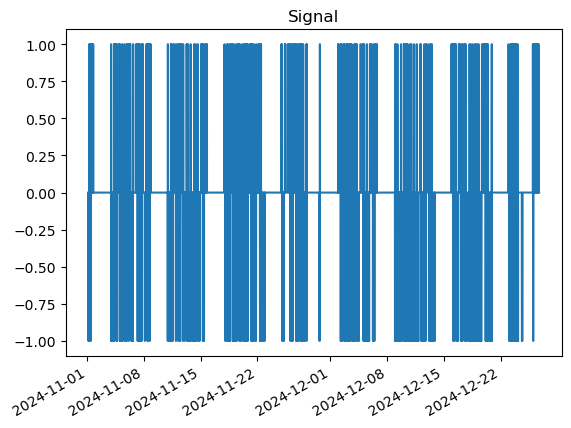

In [182]:
final_signal.tail(252).plot(title="Signal") 
plt.show()

final_signal.head(252).plot(title="Signal") 
plt.show()

final_signal.plot(title="Signal") 
plt.show()

C:\Users\marcu\AppData\Local\Temp\ipykernel_25160\3583795037.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (final_signal * spread.pct_change()).cumsum().plot(figsize=(15, 7.5), title="Treasury Futures RV Trade - Non-Compounded Cumulative Return")


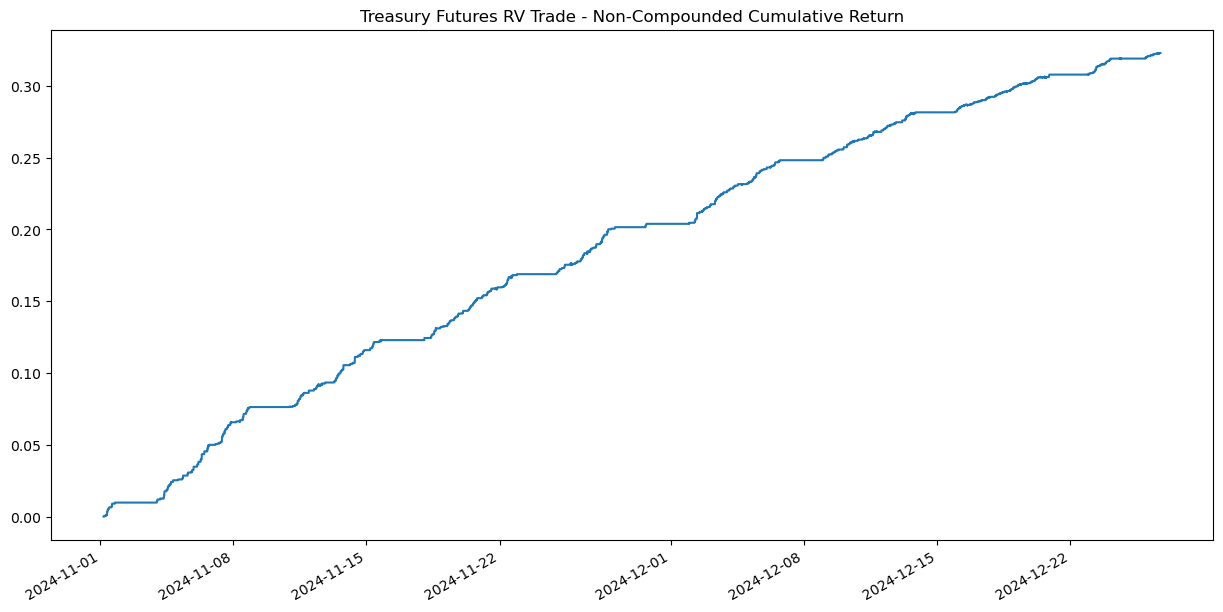

In [ ]:
# Apply signal to the next period's returns
(final_signal * spread.pct_change()).cumsum().plot(figsize=(15, 7.5), title="Treasury Futures RV Trade - Non-Compounded Cumulative Return")
plt.show()

In [125]:
signal[(signal == 1) | (signal == -1)]

Datetime
2024-11-01 06:05:00+00:00   -1
2024-11-01 06:10:00+00:00   -1
2024-11-01 07:00:00+00:00   -1
2024-11-01 08:50:00+00:00   -1
2024-11-01 09:50:00+00:00    1
                            ..
2024-12-23 13:30:00+00:00   -1
2024-12-23 14:35:00+00:00   -1
2024-12-24 14:30:00+00:00    1
2024-12-24 14:45:00+00:00    1
2024-12-24 14:50:00+00:00    1
Name: Close, Length: 299, dtype: int32

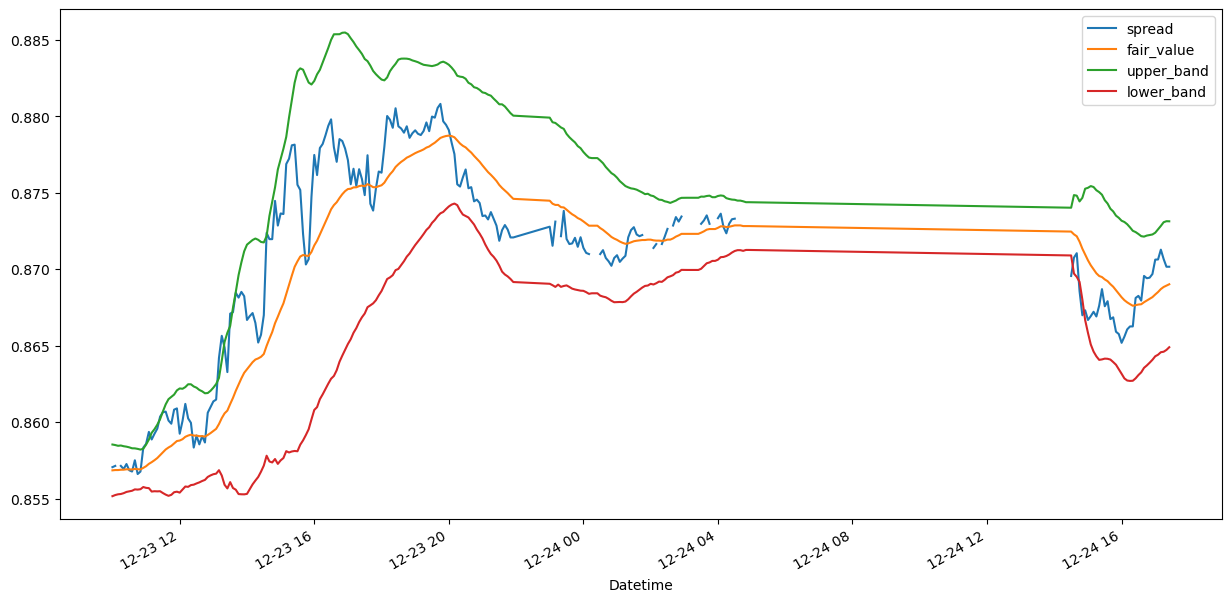

In [126]:
signal_data = pd.concat([spread, fair_value, upper_band, lower_band], axis=1)
signal_data.columns = ["spread", "fair_value", "upper_band", "lower_band"]

signal_data.tail(252).plot(figsize=(15, 7.5))
plt.show()